#### 1.1	Description of the Task

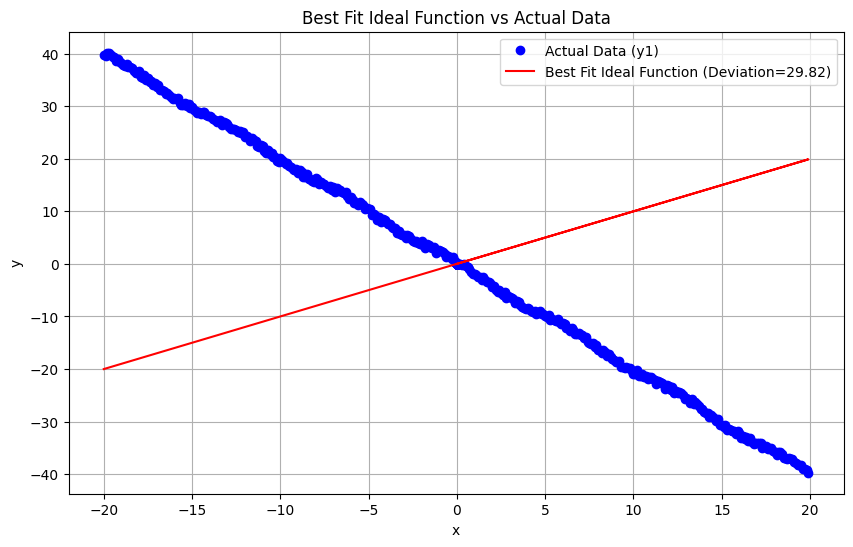

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Function to define an ideal function, e.g., a quadratic function
def ideal_function(x, a, b, c):
    return a * x**2 + b * x + c

# Function to calculate the Least-Square deviation
def least_square_deviation(y_actual, y_predicted):
    return np.sum((y_actual - y_predicted)**2)

# Read the dataset from CSV file
dataset = pd.read_csv('Dataset.csv')

# Handle missing values by filling them with zeros
dataset.fillna(0, inplace=True)

x_data = dataset['x']
y_data = dataset.iloc[:, 1:]

# Create a list to store the ideal functions and their deviations
ideal_functions = []

# Loop through 50 ideal functions (C) and calculate deviations
for i in range(1, 5):  # Assuming you want to calculate deviations for y1, y2, y3, and y4
    params, _ = curve_fit(ideal_function, x_data, y_data.iloc[:, i-1])
    y_predicted = ideal_function(x_data, *params)
    deviation = least_square_deviation(y_data.iloc[:, i-1], y_predicted)
    ideal_functions.append((params, deviation))

# Sort the ideal functions by deviation and select the best one
ideal_functions.sort(key=lambda x: x[1])
best_ideal_function_params, best_deviation = ideal_functions[0]

# Visualize the best fit ideal function and the actual data
y_best_fit = ideal_function(x_data, *best_ideal_function_params)

plt.figure(figsize=(10, 6))
plt.plot(x_data, y_data.iloc[:, 0], 'bo', label='Actual Data (y1)')
plt.plot(x_data, y_best_fit, 'r-', label=f'Best Fit Ideal Function (Deviation={best_deviation:.2f})')
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.title('Best Fit Ideal Function vs Actual Data')
plt.grid(True)
plt.show()


In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Read the original dataset from CSV
dataset = pd.read_csv('Dataset.csv')

# Split the dataset into training and test sets (e.g., 80% training, 20% test)
train_data, test_data = train_test_split(dataset, test_size=0.2, random_state=42)

# Save the training and test datasets to separate CSV files
train_data.to_csv('training_dataset.csv', index=False)
test_data.to_csv('test_dataset.csv', index=False)

print("Training and test datasets saved successfully.")


Training and test datasets saved successfully.


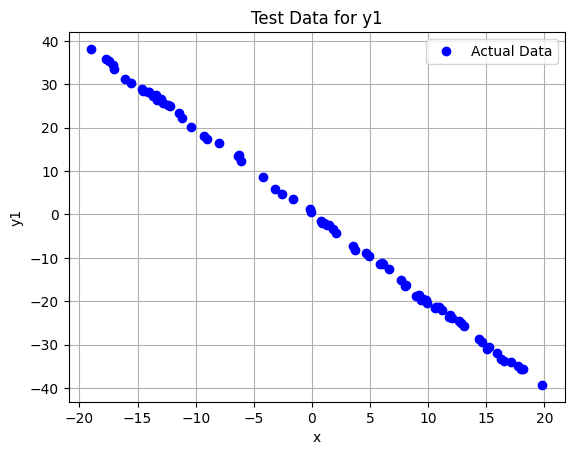

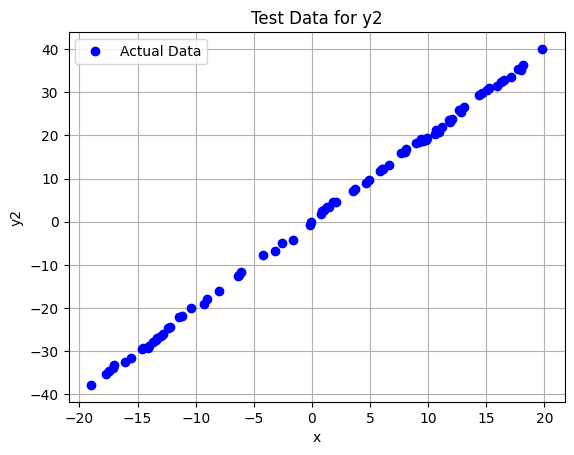

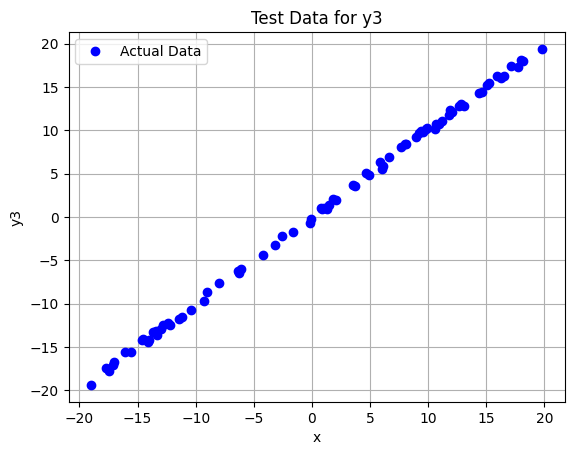

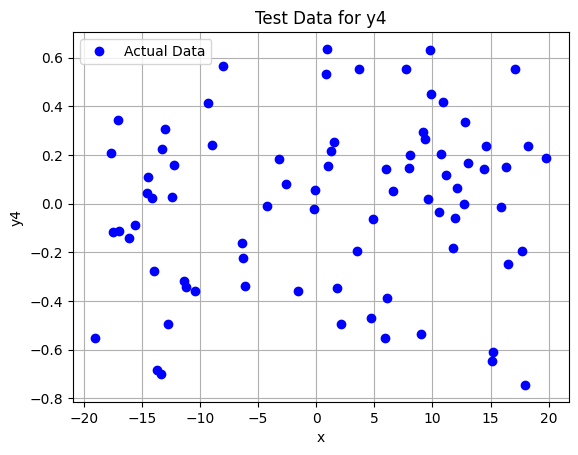

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.model_selection import train_test_split

# Function to define an ideal function, e.g., a quadratic function
def ideal_function(x, a, b, c):
    return a * x**2 + b * x + c

# Function to calculate the Least-Square deviation
def least_square_deviation(y_actual, y_predicted):
    return np.sum((np.array(y_actual) - np.array(y_predicted))**2)

# Function to determine if a data point can be assigned to an ideal function
def can_assign_to_ideal_function(x, y_actual, ideal_function_params, max_deviation):
    y_predicted = ideal_function(x, *ideal_function_params)
    deviation = least_square_deviation(y_actual, y_predicted)
    return deviation <= max_deviation

# Read the original dataset from CSV
dataset = pd.read_csv('Dataset.csv')

# Split the dataset into training and test sets (e.g., 80% training, 20% test)
train_data, test_data = train_test_split(dataset, test_size=0.2, random_state=42)

# Save the training and test datasets to separate CSV files
train_data.to_csv('training_dataset.csv', index=False)
test_data.to_csv('test_dataset.csv', index=False)

# Read the training dataset from CSV file
training_dataset = pd.read_csv('training_dataset.csv')
x_train = training_dataset['x']
y_train = training_dataset.iloc[:, 1:]

# Replace NaN and Inf values in training data with zeros
y_train = y_train.fillna(0)
y_train = y_train.replace([np.inf, -np.inf], 0)

# Read the test dataset from CSV file
test_dataset = pd.read_csv('test_dataset.csv')
x_test = test_dataset['x']
y_test = test_dataset.iloc[:, 1:]

# Initialize lists to store results
results = []

# Iterate through test data and map to the best-fit ideal functions for each column
for i in range(1, 5):  # Assuming you want to calculate deviations for y1, y2, y3, and y4
    # Fit the best-fit ideal function for the current column of y_train
    params, _ = curve_fit(ideal_function, x_train, y_train.iloc[:, i-1])

    # Calculate the maximum deviation based on the current column
    y_train_predicted = ideal_function(x_train, *params)
    max_deviation = np.sqrt(2) * least_square_deviation(y_train.iloc[:, i-1], y_train_predicted)

    # Map the test data to the ideal function for the current column
    mapping_results = []
    for j, x in enumerate(x_test):
        y_actual = y_test.iloc[j, i-1]
        if can_assign_to_ideal_function(x, y_actual, params, max_deviation):
            y_predicted = ideal_function(x, *params)
            mapping_results.append((y_predicted, least_square_deviation([y_actual], [y_predicted])))
    results.append(mapping_results)

# Visualize the results
for i in range(1, 5):
    plt.figure()
    plt.plot(x_test, y_test.iloc[:, i-1], 'bo', label='Actual Data')
    for mapping_results in results[i-1]:
        y_predicted, deviation = mapping_results
        plt.plot(x_test, [y_predicted] * len(x_test), label=f'Predicted (Deviation={deviation:.2f})')
    plt.legend()
    plt.title(f'Test Data for y{i}')
    plt.xlabel('x')
    plt.ylabel(f'y{i}')
    plt.grid(True)
    plt.show()


#### 1.2 Details

Establishing a database and designing three tables—one for training data, one for ideal functions, and one for test data with mapping and deviation.


In [17]:
from sqlalchemy import create_engine, Column, Integer, Float
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy.orm import sessionmaker

# Create a SQLite database file and an SQLAlchemy engine
engine = create_engine('sqlite:///my_database.db')

# Create a base class for declarative models
Base = declarative_base()

# Define the TrainingData table
class TrainingData(Base):
    __tablename__ = 'training_data'

    id = Column(Integer, primary_key=True)
    x = Column(Float)
    y1 = Column(Float)
    y2 = Column(Float)
    y3 = Column(Float)
    y4 = Column(Float)

# Define the IdealFunctions table
class IdealFunctions(Base):
    __tablename__ = 'ideal_functions'

    id = Column(Integer, primary_key=True)
    x = Column(Float)
    y1 = Column(Float)
    y2 = Column(Float)
    # ... Add columns for y3, y4, y5, ..., y50

# Define the TestData table
class TestData(Base):
    __tablename__ = 'test_data'

    id = Column(Integer, primary_key=True)
    x = Column(Float)
    y = Column(Float)
    delta_y = Column(Float)
    ideal_function_id = Column(Integer)

# Create the tables in the database
Base.metadata.create_all(engine)

# Create a session to interact with the database
Session = sessionmaker(bind=engine)
session = Session()


C:\Users\SPY\AppData\Local\Temp\ipykernel_20828\1112837048.py:9: MovedIn20Warning: The ``declarative_base()`` function is now available as sqlalchemy.orm.declarative_base(). (deprecated since: 2.0) (Background on SQLAlchemy 2.0 at: https://sqlalche.me/e/b8d9)
  Base = declarative_base()


The database's layout, which includes tables for test data, ideal functions, and training data. To add information to these tables, utilise SQLAlchemy.

We may use Pandas to read CSV files and then insert the data into the appropriate tables to import data from CSV files into these databases. Here is an illustration of how to load training data:


In [19]:
# Read training data from CSV
training_data_df = pd.read_csv('./training_dataset.csv')

# Loop through the training data and insert records into the TrainingData table
for index, row in training_data_df.iterrows():
    training_data = TrainingData(x=row['x'], y1=row['y1'], y2=row['y2'], y3=row['y3'], y4=row['y4'])
    session.add(training_data)

# Commit the changes to the database
session.commit()


We may make interactive plots to present the findings for visualisation using Bokeh.


In [20]:
from bokeh.plotting import figure, show
from bokeh.layouts import column
from bokeh.models import ColumnDataSource, HoverTool


Get ready to visualise our data. The information that we've kept in our database tables can be used.

Bokeh figures should be made for our plots.


In [27]:
# Assuming you have SQLAlchemy models for training data, ideal functions, and test data

# Define a function to convert SQLAlchemy model data to dictionaries
def model_to_dict(model):
    return {column.name: getattr(model, column.name) for column in model.__table__.columns}

# Convert your data to dictionaries
training_data_dict = [model_to_dict(row) for row in session.query(TrainingData).all()]
ideal_functions_data_dict = [model_to_dict(row) for row in session.query(IdealFunctions).all()]
test_data_dict = [model_to_dict(row) for row in session.query(TestData).all()]

# Create Bokeh figures for your data
training_source = ColumnDataSource(training_data_dict)
ideal_functions_source = ColumnDataSource(ideal_functions_data_dict)
test_source = ColumnDataSource(test_data_dict)

# Create Bokeh figures using the ColumnDataSources
training_plot = figure(title="Training Data", x_axis_label="X", y_axis_label="Y")
training_plot.circle('x', 'y1', source=training_source, size=8, legend_label="Y1")

ideal_functions_plot = figure(title="Ideal Functions", x_axis_label="X", y_axis_label="Y")
ideal_functions_plot.line('x', 'y1', source=ideal_functions_source, line_color="blue", legend_label="Y1")

test_plot = figure(title="Test Data with Mapping", x_axis_label="X", y_axis_label="Y")
test_plot.circle('x', 'y', source=test_source, size=8, legend_label="Test Data", color="green")

# Customize the figures (e.g., add legends, tooltips, etc.)
training_plot.legend.click_policy = "hide"
ideal_functions_plot.legend.click_policy = "hide"

# Add tooltips to the test_plot for mapping results
hover = HoverTool()
hover.tooltips = [("Ideal Function", "@ideal_function_id"), ("Deviation", "@delta_y")]
test_plot.add_tools(hover)


ValueError: expected a dict or pandas.DataFrame, got [{'id': 1, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 2, 'x': 8.6, 'y1': -17.189701, 'y2': 17.435818, 'y3': 8.227275, 'y4': -0.44056815}, {'id': 3, 'x': -3.5, 'y1': 6.7666287, 'y2': -6.8240495, 'y3': -3.6156268, 'y4': 0.12181739}, {'id': 4, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 5, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 6, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 7, 'x': -13.5, 'y1': 27.010479, 'y2': -27.046322, 'y3': -13.545402, 'y4': -0.050601155}, {'id': 8, 'x': -5.9, 'y1': 12.19691, 'y2': -11.479572, 'y3': -6.3188567, 'y4': 0.36211476}, {'id': 9, 'x': 4.4, 'y1': -9.040454, 'y2': 8.777628, 'y3': 4.116486, 'y4': -0.013107043}, {'id': 10, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 11, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 12, 'x': 11.0, 'y1': -21.527626, 'y2': 21.472301, 'y3': 10.563113, 'y4': 0.144698}, {'id': 13, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 14, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 15, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 16, 'x': 5.6, 'y1': -10.963025, 'y2': 11.187377, 'y3': 5.3071666, 'y4': 0.18401627}, {'id': 17, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 18, 'x': 18.1, 'y1': -36.30088, 'y2': 35.37216, 'y3': 17.777355, 'y4': 0.059285138}, {'id': 19, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 20, 'x': -15.1, 'y1': 29.629843, 'y2': -30.895721, 'y3': -15.373958, 'y4': 0.39804256}, {'id': 21, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 22, 'x': 5.4, 'y1': -10.567238, 'y2': 9.958612, 'y3': 5.397447, 'y4': -0.2292441}, {'id': 23, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 24, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 25, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 26, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 27, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 28, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 29, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 30, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 31, 'x': -16.7, 'y1': 33.003006, 'y2': -33.15249, 'y3': -16.823805, 'y4': -0.11059754}, {'id': 32, 'x': -16.9, 'y1': 33.971043, 'y2': -33.033516, 'y3': -16.62859, 'y4': -0.2902285}, {'id': 33, 'x': 3.1, 'y1': -6.462713, 'y2': 6.409367, 'y3': 2.6278996, 'y4': -0.45228106}, {'id': 34, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 35, 'x': -0.8, 'y1': 2.1837018, 'y2': -1.9933729, 'y3': -0.7980047, 'y4': -0.18901123}, {'id': 36, 'x': 13.2, 'y1': -26.445644, 'y2': 26.884226, 'y3': 13.391185, 'y4': 0.4074397}, {'id': 37, 'x': -19.7, 'y1': 40.1511, 'y2': -39.518402, 'y3': -19.389118, 'y4': -0.6120442}, {'id': 38, 'x': 0.4, 'y1': -0.018686488, 'y2': 0.5643063, 'y3': 0.30977216, 'y4': 0.38640434}, {'id': 39, 'x': 12.3, 'y1': -24.46831, 'y2': 23.992142, 'y3': 11.977918, 'y4': -0.36666742}, {'id': 40, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 41, 'x': 10.5, 'y1': -20.935947, 'y2': 20.486355, 'y3': 10.414769, 'y4': 0.30863875}, {'id': 42, 'x': -9.1, 'y1': 18.091381, 'y2': -18.2001, 'y3': -8.984978, 'y4': 0.22550505}, {'id': 43, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 44, 'x': -12.3, 'y1': 25.348244, 'y2': -24.475128, 'y3': -11.995999, 'y4': 0.1656311}, {'id': 45, 'x': -11.6, 'y1': 23.880903, 'y2': -22.600348, 'y3': -11.964934, 'y4': -0.03453156}, {'id': 46, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 47, 'x': -11.8, 'y1': 24.016615, 'y2': -23.546015, 'y3': -11.714512, 'y4': 0.66258484}, {'id': 48, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 49, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 50, 'x': 16.2, 'y1': -32.75864, 'y2': 32.0974, 'y3': 16.197481, 'y4': 0.49302992}, {'id': 51, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 52, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 53, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 54, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 55, 'x': -19.8, 'y1': 40.09907, 'y2': -40.018845, 'y3': -19.906782, 'y4': -0.4518296}, {'id': 56, 'x': -9.9, 'y1': 19.6761, 'y2': -19.831825, 'y3': -9.661298, 'y4': -0.13811694}, {'id': 57, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 58, 'x': 7.5, 'y1': -15.078565, 'y2': 15.49476, 'y3': 7.926474, 'y4': 0.120362505}, {'id': 59, 'x': -19.5, 'y1': 39.340855, 'y2': -38.90581, 'y3': -19.287113, 'y4': -0.062154666}, {'id': 60, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 61, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 62, 'x': -10.3, 'y1': 20.255909, 'y2': -20.585495, 'y3': -9.98029, 'y4': -0.18458326}, {'id': 63, 'x': 6.5, 'y1': -12.164364, 'y2': 13.605263, 'y3': 6.175998, 'y4': 0.019376835}, {'id': 64, 'x': 15.5, 'y1': -31.62523, 'y2': 31.402412, 'y3': 15.601245, 'y4': 0.38331792}, {'id': 65, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 66, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 67, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 68, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 69, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 70, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 71, 'x': -8.2, 'y1': 15.746574, 'y2': -16.957348, 'y3': -8.436194, 'y4': 0.07858246}, {'id': 72, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 73, 'x': 5.0, 'y1': -9.9565735, 'y2': 9.934185, 'y3': 4.595946, 'y4': 0.19906275}, {'id': 74, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 75, 'x': -19.1, 'y1': 38.364567, 'y2': -38.354656, 'y3': -18.75372, 'y4': -0.29954198}, {'id': 76, 'x': -0.4, 'y1': 1.2836223, 'y2': -1.3788683, 'y3': -0.30024347, 'y4': -0.35375693}, {'id': 77, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 78, 'x': -11.9, 'y1': 24.248436, 'y2': -23.587065, 'y3': -11.686815, 'y4': 0.41648862}, {'id': 79, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 80, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 81, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 82, 'x': 3.9, 'y1': -8.515413, 'y2': 7.3003263, 'y3': 3.7917917, 'y4': -0.17881162}, {'id': 83, 'x': 8.9, 'y1': -18.275639, 'y2': 18.458288, 'y3': 8.521817, 'y4': -0.3574315}, {'id': 84, 'x': 1.1, 'y1': -2.1719763, 'y2': 2.261257, 'y3': 1.4936, 'y4': 0.45722613}, {'id': 85, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 86, 'x': 15.7, 'y1': -31.871979, 'y2': 31.813738, 'y3': 15.7822485, 'y4': -0.28359264}, {'id': 87, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 88, 'x': 2.7, 'y1': -5.4164214, 'y2': 5.7853413, 'y3': 2.399775, 'y4': 0.17156993}, {'id': 89, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 90, 'x': 16.1, 'y1': -33.091797, 'y2': 32.366974, 'y3': 16.226398, 'y4': -0.12817435}, {'id': 91, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 92, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 93, 'x': 18.8, 'y1': -37.016827, 'y2': 37.18756, 'y3': 19.109936, 'y4': 0.28533506}, {'id': 94, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 95, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 96, 'x': 11.4, 'y1': -22.218653, 'y2': 22.834936, 'y3': 11.410645, 'y4': -0.63258076}, {'id': 97, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 98, 'x': -19.3, 'y1': 38.590164, 'y2': -38.62107, 'y3': -19.494537, 'y4': -0.2690418}, {'id': 99, 'x': -4.5, 'y1': 8.4033785, 'y2': -8.350241, 'y3': -4.7953453, 'y4': 0.017843474}, {'id': 100, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 101, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 102, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 103, 'x': 19.4, 'y1': -38.26618, 'y2': 39.50271, 'y3': 19.512674, 'y4': 0.5121437}, {'id': 104, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 105, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 106, 'x': 13.3, 'y1': -25.773245, 'y2': 27.121273, 'y3': 13.403583, 'y4': 0.6342896}, {'id': 107, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 108, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 109, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 110, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 111, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 112, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 113, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 114, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 115, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 116, 'x': 2.8, 'y1': -6.4128246, 'y2': 6.2258534, 'y3': 2.435753, 'y4': 0.106000185}, {'id': 117, 'x': 15.0, 'y1': -30.711563, 'y2': 30.776638, 'y3': 14.933819, 'y4': -0.017378539}, {'id': 118, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 119, 'x': 1.2, 'y1': -2.4825113, 'y2': 2.3822875, 'y3': 1.0333862, 'y4': 0.31480712}, {'id': 120, 'x': -12.1, 'y1': 25.083504, 'y2': -23.531492, 'y3': -12.261272, 'y4': -0.001653088}, {'id': 121, 'x': -5.2, 'y1': 10.486, 'y2': -9.530538, 'y3': -4.9070063, 'y4': -0.043267846}, {'id': 122, 'x': 10.2, 'y1': -20.27364, 'y2': 20.536623, 'y3': 10.216859, 'y4': -0.15099001}, {'id': 123, 'x': 13.4, 'y1': -26.662289, 'y2': 27.60885, 'y3': 13.611903, 'y4': 0.2733398}, {'id': 124, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 125, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 126, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 127, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 128, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 129, 'x': -6.7, 'y1': 13.849966, 'y2': -13.1873455, 'y3': -6.839167, 'y4': -0.44084644}, {'id': 130, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 131, 'x': 11.1, 'y1': -21.940367, 'y2': 22.159431, 'y3': 11.227488, 'y4': 0.3527}, {'id': 132, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 133, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 134, 'x': -20.0, 'y1': 39.778572, 'y2': -40.07859, 'y3': -20.214268, 'y4': -0.32491425}, {'id': 135, 'x': 11.6, 'y1': -22.579548, 'y2': 23.245441, 'y3': 11.280111, 'y4': -0.16724028}, {'id': 136, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 137, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 138, 'x': 14.2, 'y1': -28.4435, 'y2': 29.078094, 'y3': 14.072357, 'y4': -0.5184432}, {'id': 139, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 140, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 141, 'x': 17.0, 'y1': -34.01081, 'y2': 33.17378, 'y3': 17.359114, 'y4': 0.39705846}, {'id': 142, 'x': -2.8, 'y1': 5.526654, 'y2': -6.1166887, 'y3': -2.370068, 'y4': 0.6138541}, {'id': 143, 'x': -7.5, 'y1': 15.170431, 'y2': -15.791869, 'y3': -7.5496445, 'y4': -0.6327828}, {'id': 144, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 145, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 146, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 147, 'x': -11.0, 'y1': 22.341274, 'y2': -21.440613, 'y3': -10.796314, 'y4': 0.22407265}, {'id': 148, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 149, 'x': -1.9, 'y1': 3.6676173, 'y2': -3.9402707, 'y3': -2.2605774, 'y4': 0.25310782}, {'id': 150, 'x': 7.4, 'y1': -14.816493, 'y2': 15.081034, 'y3': 6.9987493, 'y4': 0.2956616}, {'id': 151, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 152, 'x': -13.1, 'y1': 26.715807, 'y2': -26.272911, 'y3': -13.044477, 'y4': 0.031488232}, {'id': 153, 'x': 9.1, 'y1': -18.741985, 'y2': 17.887392, 'y3': 9.441199, 'y4': -0.086609}, {'id': 154, 'x': -6.9, 'y1': 13.72398, 'y2': -13.691697, 'y3': -6.480628, 'y4': 0.26347908}, {'id': 155, 'x': 10.0, 'y1': -20.911, 'y2': 19.517511, 'y3': 9.827649, 'y4': 0.1767603}, {'id': 156, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 157, 'x': 12.6, 'y1': -24.380707, 'y2': 25.066849, 'y3': 12.500277, 'y4': 0.08078157}, {'id': 158, 'x': -5.6, 'y1': 11.190752, 'y2': -11.336878, 'y3': -5.8103137, 'y4': 0.13259691}, {'id': 159, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 160, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 161, 'x': -6.5, 'y1': 13.683014, 'y2': -13.57312, 'y3': -6.343632, 'y4': -0.13636306}, {'id': 162, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 163, 'x': -3.6, 'y1': 6.7658954, 'y2': -7.168956, 'y3': -3.423373, 'y4': -0.39109442}, {'id': 164, 'x': -17.2, 'y1': 34.099274, 'y2': -33.4363, 'y3': -17.28941, 'y4': -0.14619163}, {'id': 165, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 166, 'x': -0.7, 'y1': 1.793958, 'y2': -1.8276277, 'y3': -0.8285642, 'y4': -0.16037779}, {'id': 167, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 168, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 169, 'x': -3.1, 'y1': 5.418435, 'y2': -6.2593627, 'y3': -3.4713101, 'y4': 0.22197495}, {'id': 170, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 171, 'x': -6.0, 'y1': 12.770117, 'y2': -11.887695, 'y3': -5.5694, 'y4': 0.6109282}, {'id': 172, 'x': -2.7, 'y1': 5.284998, 'y2': -6.027501, 'y3': -2.9662678, 'y4': 0.3741298}, {'id': 173, 'x': -19.4, 'y1': 39.25246, 'y2': -39.12036, 'y3': -19.683708, 'y4': 0.026392838}, {'id': 174, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 175, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 176, 'x': -12.7, 'y1': 25.730907, 'y2': -25.139296, 'y3': -13.033004, 'y4': 0.051321585}, {'id': 177, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 178, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 179, 'x': 3.8, 'y1': -8.443102, 'y2': 7.02371, 'y3': 3.7552803, 'y4': 0.33335227}, {'id': 180, 'x': -5.5, 'y1': 11.671036, 'y2': -11.127859, 'y3': -5.3072863, 'y4': 0.41284594}, {'id': 181, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 182, 'x': 3.4, 'y1': -6.979451, 'y2': 6.644011, 'y3': 3.0553632, 'y4': 0.001361962}, {'id': 183, 'x': 2.0, 'y1': -4.315145, 'y2': 4.0863957, 'y3': 2.337437, 'y4': -0.33067894}, {'id': 184, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 185, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 186, 'x': -6.8, 'y1': 14.393147, 'y2': -13.8938265, 'y3': -6.9007196, 'y4': -0.019564947}, {'id': 187, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 188, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 189, 'x': -1.5, 'y1': 3.1611423, 'y2': -3.7539537, 'y3': -1.4539124, 'y4': 0.21239683}, {'id': 190, 'x': -15.9, 'y1': 31.377129, 'y2': -31.849277, 'y3': -15.54072, 'y4': 0.083608545}, {'id': 191, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 192, 'x': -9.2, 'y1': 17.831709, 'y2': -18.887852, 'y3': -9.356181, 'y4': -0.2593116}, {'id': 193, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 194, 'x': -14.4, 'y1': 28.961216, 'y2': -28.957647, 'y3': -14.142215, 'y4': 0.38398743}, {'id': 195, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 196, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 197, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 198, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 199, 'x': -17.6, 'y1': 35.009613, 'y2': -35.05815, 'y3': -18.051992, 'y4': -0.14993647}, {'id': 200, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 201, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 202, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 203, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 204, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 205, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 206, 'x': 13.8, 'y1': -27.55994, 'y2': 28.209953, 'y3': 13.462333, 'y4': -0.19533904}, {'id': 207, 'x': -14.9, 'y1': 29.217709, 'y2': -30.033648, 'y3': -14.589854, 'y4': 0.24456862}, {'id': 208, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 209, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 210, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 211, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 212, 'x': 6.4, 'y1': -12.688099, 'y2': 13.125281, 'y3': 6.6161866, 'y4': -0.19001625}, {'id': 213, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 214, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 215, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 216, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 217, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 218, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 219, 'x': -18.2, 'y1': 36.31057, 'y2': -35.691395, 'y3': -18.298632, 'y4': -0.15387341}, {'id': 220, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 221, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 222, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 223, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 224, 'x': 16.7, 'y1': -33.912212, 'y2': 33.232594, 'y3': 16.931856, 'y4': 0.000376412}, {'id': 225, 'x': -11.7, 'y1': 23.320929, 'y2': -22.805626, 'y3': -12.198936, 'y4': -0.02240543}, {'id': 226, 'x': -13.9, 'y1': 27.976458, 'y2': -27.830526, 'y3': -14.347666, 'y4': -0.048467655}, {'id': 227, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 228, 'x': 7.2, 'y1': -14.088579, 'y2': 14.901099, 'y3': 6.9531007, 'y4': 0.23028904}, {'id': 229, 'x': 8.5, 'y1': -17.527601, 'y2': 17.5743, 'y3': 8.645949, 'y4': 0.23374027}, {'id': 230, 'x': 16.0, 'y1': -32.16553, 'y2': 31.964392, 'y3': 15.7342005, 'y4': 0.30207548}, {'id': 231, 'x': 15.4, 'y1': -31.410114, 'y2': 30.84187, 'y3': 15.141523, 'y4': 0.24156104}, {'id': 232, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 233, 'x': 7.8, 'y1': -15.761508, 'y2': 15.633608, 'y3': 7.99477, 'y4': -0.30711728}, {'id': 234, 'x': -18.8, 'y1': 37.672874, 'y2': -37.855568, 'y3': -18.92033, 'y4': 0.0705662}, {'id': 235, 'x': -1.8, 'y1': 2.9909992, 'y2': -4.1481814, 'y3': -1.5290474, 'y4': 0.20970975}, {'id': 236, 'x': 16.8, 'y1': -34.196957, 'y2': 33.456802, 'y3': 16.938702, 'y4': 0.44506484}, {'id': 237, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 238, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 239, 'x': 2.3, 'y1': -5.2790227, 'y2': 4.9983487, 'y3': 2.6416962, 'y4': -0.7196921}, {'id': 240, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 241, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 242, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 243, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 244, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 245, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 246, 'x': -2.4, 'y1': 4.191226, 'y2': -4.7433724, 'y3': -2.6651213, 'y4': 0.58884114}, {'id': 247, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 248, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 249, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 250, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 251, 'x': 19.3, 'y1': -38.234627, 'y2': 38.604515, 'y3': 19.643005, 'y4': 0.015280819}, {'id': 252, 'x': -3.7, 'y1': 6.9436646, 'y2': -6.8622985, 'y3': -4.0255666, 'y4': -0.072027445}, {'id': 253, 'x': 4.8, 'y1': -9.532464, 'y2': 8.620599, 'y3': 5.012731, 'y4': -0.09327436}, {'id': 254, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 255, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 256, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 257, 'x': 17.5, 'y1': -34.705803, 'y2': 34.167114, 'y3': 17.326437, 'y4': -0.39023623}, {'id': 258, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 259, 'x': -12.6, 'y1': 25.571356, 'y2': -25.608099, 'y3': -12.2511425, 'y4': 0.3909315}, {'id': 260, 'x': -8.7, 'y1': 16.597107, 'y2': -17.40592, 'y3': -8.726125, 'y4': 0.23579614}, {'id': 261, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 262, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 263, 'x': 19.0, 'y1': -37.09927, 'y2': 38.15769, 'y3': 19.348995, 'y4': -0.31859457}, {'id': 264, 'x': -9.6, 'y1': 19.146034, 'y2': -19.605854, 'y3': -10.092775, 'y4': -0.11615117}, {'id': 265, 'x': -8.6, 'y1': 16.546343, 'y2': -17.703665, 'y3': -8.885028, 'y4': 0.33037788}, {'id': 266, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 267, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 268, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 269, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 270, 'x': -10.8, 'y1': 21.09595, 'y2': -21.535612, 'y3': -10.97698, 'y4': -0.57189953}, {'id': 271, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 272, 'x': -11.1, 'y1': 22.532522, 'y2': -21.403929, 'y3': -10.899252, 'y4': 0.21685402}, {'id': 273, 'x': 13.6, 'y1': -26.730398, 'y2': 27.209805, 'y3': 13.286281, 'y4': 0.69450223}, {'id': 274, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 275, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 276, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 277, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 278, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 279, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 280, 'x': -10.6, 'y1': 20.96303, 'y2': -20.33526, 'y3': -10.124289, 'y4': 0.1746914}, {'id': 281, 'x': -18.9, 'y1': 37.825813, 'y2': -37.984848, 'y3': -18.528309, 'y4': 0.040018722}, {'id': 282, 'x': 19.6, 'y1': -39.106945, 'y2': 39.06788, 'y3': 19.840752, 'y4': 0.63842297}, {'id': 283, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 284, 'x': -15.7, 'y1': 30.581562, 'y2': -31.266651, 'y3': -16.140867, 'y4': -0.3180933}, {'id': 285, 'x': -15.8, 'y1': 31.465273, 'y2': -31.789133, 'y3': -15.530875, 'y4': -0.003845878}, {'id': 286, 'x': 12.9, 'y1': -25.653263, 'y2': 26.339453, 'y3': 13.3239155, 'y4': 0.6295268}, {'id': 287, 'x': -3.3, 'y1': 6.280164, 'y2': -6.118162, 'y3': -3.3633964, 'y4': -0.43865138}, {'id': 288, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 289, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 290, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 291, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 292, 'x': -10.0, 'y1': 20.072577, 'y2': -19.489513, 'y3': -10.058358, 'y4': 0.24360992}, {'id': 293, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 294, 'x': -2.2, 'y1': 3.8973043, 'y2': -5.073695, 'y3': -1.905655, 'y4': -0.117682084}, {'id': 295, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 296, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 297, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 298, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 299, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 300, 'x': -2.3, 'y1': 4.3178387, 'y2': -5.33609, 'y3': -1.8943019, 'y4': -0.14863284}, {'id': 301, 'x': 19.5, 'y1': -38.254158, 'y2': 39.661987, 'y3': 19.536741, 'y4': 0.69515765}, {'id': 302, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 303, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 304, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 305, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 306, 'x': 18.3, 'y1': -35.823513, 'y2': 36.65842, 'y3': 17.841272, 'y4': -0.046279155}, {'id': 307, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 308, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 309, 'x': 5.7, 'y1': -10.581513, 'y2': 10.789379, 'y3': 6.0118165, 'y4': -0.6379255}, {'id': 310, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 311, 'x': 13.5, 'y1': -26.31488, 'y2': 27.08055, 'y3': 13.560992, 'y4': 0.115751594}, {'id': 312, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 313, 'x': -18.5, 'y1': 37.429653, 'y2': -37.083054, 'y3': -18.551897, 'y4': -0.001835507}, {'id': 314, 'x': 12.4, 'y1': -24.172283, 'y2': 24.966301, 'y3': 12.5943775, 'y4': -0.0995046}, {'id': 315, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 316, 'x': 2.2, 'y1': -4.993769, 'y2': 5.235695, 'y3': 2.2626762, 'y4': -0.32811776}, {'id': 317, 'x': -2.1, 'y1': 3.844888, 'y2': -5.061652, 'y3': -1.6684194, 'y4': 0.05557271}, {'id': 318, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 319, 'x': -17.8, 'y1': 35.421272, 'y2': -35.432663, 'y3': -17.929127, 'y4': -0.08499361}, {'id': 320, 'x': 15.6, 'y1': -31.826422, 'y2': 30.781027, 'y3': 15.810299, 'y4': -0.018533107}, {'id': 321, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 322, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 323, 'x': 14.0, 'y1': -28.183325, 'y2': 28.380262, 'y3': 14.200884, 'y4': 0.52278435}, {'id': 324, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 325, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 326, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 327, 'x': 0.3, 'y1': -0.14410558, 'y2': 0.2643344, 'y3': 0.42635018, 'y4': 0.5239853}, {'id': 328, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 329, 'x': -10.7, 'y1': 21.697912, 'y2': -21.374477, 'y3': -10.89252, 'y4': -0.047246568}, {'id': 330, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 331, 'x': -13.2, 'y1': 27.011068, 'y2': -27.134518, 'y3': -13.620864, 'y4': -0.65312505}, {'id': 332, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 333, 'x': 8.4, 'y1': -16.742565, 'y2': 17.614395, 'y3': 8.697577, 'y4': 0.04541092}, {'id': 334, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 335, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 336, 'x': -4.7, 'y1': 9.4822035, 'y2': -9.037607, 'y3': -4.420576, 'y4': -0.12405812}, {'id': 337, 'x': -12.5, 'y1': 25.54436, 'y2': -25.107195, 'y3': -12.507834, 'y4': -0.17399704}, {'id': 338, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 339, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 340, 'x': -1.2, 'y1': 2.156345, 'y2': -3.0180886, 'y3': -1.3117605, 'y4': 0.18843833}, {'id': 341, 'x': 7.1, 'y1': -13.438077, 'y2': 14.890244, 'y3': 7.2253356, 'y4': 0.0901426}, {'id': 342, 'x': 3.6, 'y1': -7.7492247, 'y2': 6.493291, 'y3': 3.2864027, 'y4': -0.15205123}, {'id': 343, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 344, 'x': -8.3, 'y1': 16.103878, 'y2': -16.877802, 'y3': -8.572217, 'y4': -0.0810489}, {'id': 345, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 346, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 347, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 348, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 349, 'x': -7.4, 'y1': 14.878976, 'y2': -15.018995, 'y3': -7.328601, 'y4': -0.1484294}, {'id': 350, 'x': -8.4, 'y1': 16.093102, 'y2': -16.918701, 'y3': -8.525435, 'y4': 0.11099869}, {'id': 351, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 352, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 353, 'x': -14.3, 'y1': 28.921854, 'y2': -29.341013, 'y3': -14.107099, 'y4': 0.294356}, {'id': 354, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 355, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 356, 'x': 16.9, 'y1': -34.078842, 'y2': 33.565544, 'y3': 16.711296, 'y4': -0.05908312}, {'id': 357, 'x': 6.8, 'y1': -13.343458, 'y2': 13.8175335, 'y3': 6.58489, 'y4': 0.5997594}, {'id': 358, 'x': -15.4, 'y1': 30.506998, 'y2': -31.34851, 'y3': -15.176161, 'y4': 0.022070993}, {'id': 359, 'x': 14.9, 'y1': -30.60605, 'y2': 30.266047, 'y3': 14.512153, 'y4': -0.63605857}, {'id': 360, 'x': -0.5, 'y1': 1.4369066, 'y2': -1.1802436, 'y3': -0.30000493, 'y4': -0.121132955}, {'id': 361, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 362, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 363, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 364, 'x': 6.3, 'y1': -12.202671, 'y2': 12.24383, 'y3': 6.6738214, 'y4': -0.24922097}, {'id': 365, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 366, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 367, 'x': 10.4, 'y1': -21.416916, 'y2': 20.51084, 'y3': 10.044789, 'y4': 0.38799486}, {'id': 368, 'x': 14.1, 'y1': -28.36217, 'y2': 28.53437, 'y3': 13.682309, 'y4': 0.2779828}, {'id': 369, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 370, 'x': -5.1, 'y1': 10.649805, 'y2': -9.756274, 'y3': -5.2677565, 'y4': 0.089222156}, {'id': 371, 'x': -7.6, 'y1': 15.097614, 'y2': -16.081308, 'y3': -7.2120543, 'y4': 0.010636473}, {'id': 372, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 373, 'x': -15.0, 'y1': 29.853884, 'y2': -30.701433, 'y3': -15.476767, 'y4': 0.51364607}, {'id': 374, 'x': 15.3, 'y1': -31.550097, 'y2': 30.773102, 'y3': 15.345737, 'y4': 0.046751384}, {'id': 375, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 376, 'x': -5.8, 'y1': 11.574714, 'y2': -11.649666, 'y3': -5.5815163, 'y4': 0.40015438}, {'id': 377, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 378, 'x': 19.9, 'y1': -39.724934, 'y2': 40.558865, 'y3': 19.630678, 'y4': 0.5138243}, {'id': 379, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 380, 'x': 12.0, 'y1': -23.161896, 'y2': 23.343134, 'y3': 12.41625, 'y4': -0.521474}, {'id': 381, 'x': -18.1, 'y1': 36.379223, 'y2': -35.42202, 'y3': -17.694733, 'y4': 0.6145841}, {'id': 382, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 383, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 384, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 385, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 386, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 387, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 388, 'x': -16.2, 'y1': 31.744162, 'y2': -32.208416, 'y3': -16.36914, 'y4': 0.10328723}, {'id': 389, 'x': -2.5, 'y1': 4.2834992, 'y2': -5.014349, 'y3': -2.1700747, 'y4': 0.29023385}, {'id': 390, 'x': 4.5, 'y1': -9.453603, 'y2': 8.192489, 'y3': 4.1129637, 'y4': 0.5469513}, {'id': 391, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 392, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 393, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 394, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 395, 'x': -4.6, 'y1': 9.121017, 'y2': -8.576267, 'y3': -4.35842, 'y4': -0.303996}, {'id': 396, 'x': 8.7, 'y1': -17.649586, 'y2': 17.357824, 'y3': 8.589682, 'y4': 0.14727634}, {'id': 397, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 398, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 399, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 400, 'x': -18.3, 'y1': 36.635334, 'y2': -36.5591, 'y3': -18.573486, 'y4': 0.08883932}, {'id': 401, 'x': -7.3, 'y1': 14.421107, 'y2': -15.070971, 'y3': -7.6536365, 'y4': -0.1061275}, {'id': 402, 'x': 12.2, 'y1': -23.50948, 'y2': 24.155764, 'y3': 12.219786, 'y4': 0.31796703}, {'id': 403, 'x': 5.5, 'y1': -10.688689, 'y2': 10.213659, 'y3': 5.381006, 'y4': -0.61987656}, {'id': 404, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 405, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 406, 'x': -1.0, 'y1': 2.5588133, 'y2': -2.1596348, 'y3': -0.74482834, 'y4': -0.30854103}, {'id': 407, 'x': -8.5, 'y1': 17.167364, 'y2': -17.752602, 'y3': -8.30539, 'y4': 0.33593923}, {'id': 408, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 409, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 410, 'x': -2.0, 'y1': 4.270921, 'y2': -4.5097136, 'y3': -1.6928682, 'y4': -0.12205349}, {'id': 411, 'x': 10.1, 'y1': -20.869558, 'y2': 19.466124, 'y3': 10.108967, 'y4': -0.010635532}, {'id': 412, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 413, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 414, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 415, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 416, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 417, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 418, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 419, 'x': -15.5, 'y1': 30.291279, 'y2': -31.408848, 'y3': -15.601471, 'y4': 0.44567823}, {'id': 420, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 421, 'x': -4.3, 'y1': 7.954933, 'y2': -8.244953, 'y3': -3.8611631, 'y4': 0.23242088}, {'id': 422, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 423, 'x': -2.9, 'y1': 4.9652553, 'y2': -5.434099, 'y3': -3.2628646, 'y4': -0.14994985}, {'id': 424, 'x': -18.4, 'y1': 37.330147, 'y2': -36.65041, 'y3': -18.406178, 'y4': 0.34796613}, {'id': 425, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 426, 'x': -15.2, 'y1': 30.419271, 'y2': -30.306372, 'y3': -15.377739, 'y4': -0.06104431}, {'id': 427, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 428, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 429, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 430, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 431, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 432, 'x': 8.3, 'y1': -16.331766, 'y2': 17.182362, 'y3': 7.8358, 'y4': -0.40672845}, {'id': 433, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 434, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 435, 'x': 2.5, 'y1': -5.545062, 'y2': 5.4514318, 'y3': 2.3285666, 'y4': -0.13392949}, {'id': 436, 'x': -17.4, 'y1': 34.673225, 'y2': -34.403038, 'y3': -17.254086, 'y4': 0.2630343}, {'id': 437, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 438, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 439, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 440, 'x': 16.4, 'y1': -32.85395, 'y2': 32.110725, 'y3': 16.11881, 'y4': -0.009014632}, {'id': 441, 'x': 2.9, 'y1': -6.0589466, 'y2': 6.3037295, 'y3': 3.3199935, 'y4': -0.51519614}, {'id': 442, 'x': -16.3, 'y1': 32.194664, 'y2': -32.186275, 'y3': -16.139305, 'y4': 0.23491701}, {'id': 443, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 444, 'x': 17.4, 'y1': -34.57045, 'y2': 34.09418, 'y3': 17.747175, 'y4': 0.12828024}, {'id': 445, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 446, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 447, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 448, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 449, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 450, 'x': -0.6, 'y1': 1.2511269, 'y2': -1.5066501, 'y3': -0.63735723, 'y4': -0.16356032}, {'id': 451, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 452, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 453, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 454, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 455, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 456, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 457, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 458, 'x': -3.8, 'y1': 7.589857, 'y2': -7.496997, 'y3': -4.222018, 'y4': -0.53544486}, {'id': 459, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 460, 'x': -4.8, 'y1': 9.381154, 'y2': -9.035655, 'y3': -5.270897, 'y4': 0.12032644}, {'id': 461, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 462, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 463, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 464, 'x': -8.9, 'y1': 17.799309, 'y2': -17.802477, 'y3': -8.641598, 'y4': 0.7065497}, {'id': 465, 'x': 2.6, 'y1': -5.8593044, 'y2': 5.6921225, 'y3': 2.4648361, 'y4': -0.05125017}, {'id': 466, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 467, 'x': -9.7, 'y1': 19.058212, 'y2': -18.926718, 'y3': -9.263311, 'y4': -0.39468098}, {'id': 468, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 469, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 470, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 471, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 472, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 473, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 474, 'x': -8.1, 'y1': 15.582306, 'y2': -16.944826, 'y3': -7.82068, 'y4': 0.036169287}, {'id': 475, 'x': -14.7, 'y1': 28.667645, 'y2': -29.410593, 'y3': -14.359352, 'y4': -0.1469725}, {'id': 476, 'x': -4.9, 'y1': 10.376054, 'y2': -9.068665, 'y3': -4.701068, 'y4': 0.1488276}, {'id': 477, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 478, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 479, 'x': 0.7, 'y1': -1.0624563, 'y2': 1.2783111, 'y3': 0.9332018, 'y4': 0.7424894}, {'id': 480, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 481, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 482, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 483, 'x': -19.2, 'y1': 38.893463, 'y2': -38.806778, 'y3': -19.533716, 'y4': 0.08567329}, {'id': 484, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 485, 'x': -16.4, 'y1': 32.51663, 'y2': -32.68559, 'y3': -16.269371, 'y4': -0.011137535}, {'id': 486, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 487, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 488, 'x': 5.3, 'y1': -10.727592, 'y2': 9.816332, 'y3': 5.6217585, 'y4': 0.05899392}, {'id': 489, 'x': 10.3, 'y1': -21.240631, 'y2': 20.076725, 'y3': 9.859072, 'y4': -0.13885684}, {'id': 490, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 491, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 492, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 493, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 494, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 495, 'x': 6.2, 'y1': -12.191167, 'y2': 12.117546, 'y3': 6.452319, 'y4': -0.19239196}, {'id': 496, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 497, 'x': 9.7, 'y1': -19.749565, 'y2': 19.675156, 'y3': 9.974682, 'y4': 0.12319272}, {'id': 498, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 499, 'x': -5.0, 'y1': 10.522831, 'y2': -9.092859, 'y3': -4.8167667, 'y4': 0.2228631}, {'id': 500, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 501, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 502, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 503, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 504, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 505, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 506, 'x': -5.3, 'y1': 11.164489, 'y2': -9.940487, 'y3': -4.9274735, 'y4': 0.5767008}, {'id': 507, 'x': -5.4, 'y1': 11.4051485, 'y2': -10.1569605, 'y3': -5.3916306, 'y4': 0.09114355}, {'id': 508, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 509, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 510, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 511, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 512, 'x': 14.8, 'y1': -29.477427, 'y2': 29.555119, 'y3': 14.37681, 'y4': -0.0513638}, {'id': 513, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 514, 'x': 12.5, 'y1': -24.588163, 'y2': 24.602243, 'y3': 12.602649, 'y4': 0.22165512}, {'id': 515, 'x': -1.4, 'y1': 2.979599, 'y2': -3.5428197, 'y3': -1.7365232, 'y4': -0.33532947}, {'id': 516, 'x': -7.7, 'y1': 15.616413, 'y2': -15.665973, 'y3': -7.7632246, 'y4': -0.18302464}, {'id': 517, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 518, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 519, 'x': -5.7, 'y1': 11.610783, 'y2': -10.886972, 'y3': -5.7935023, 'y4': 0.59391856}, {'id': 520, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 521, 'x': -0.3, 'y1': 0.95033836, 'y2': -0.2582402, 'y3': 0.10269363, 'y4': -0.44263187}, {'id': 522, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 523, 'x': 7.9, 'y1': -15.499742, 'y2': 16.542248, 'y3': 8.078628, 'y4': -0.4491541}, {'id': 524, 'x': 9.3, 'y1': -19.533188, 'y2': 18.488611, 'y3': 9.733899, 'y4': -0.14297304}, {'id': 525, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 526, 'x': -7.8, 'y1': 15.229189, 'y2': -15.626455, 'y3': -7.968554, 'y4': 0.44375187}, {'id': 527, 'x': -1.7, 'y1': 3.8140242, 'y2': -3.8295608, 'y3': -1.8965964, 'y4': 0.5272478}, {'id': 528, 'x': 0.2, 'y1': -0.116170295, 'y2': 0.16301854, 'y3': -0.1792003, 'y4': 0.3609613}, {'id': 529, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 530, 'x': 4.6, 'y1': -9.360153, 'y2': 8.840526, 'y3': 4.6773286, 'y4': 0.27461666}, {'id': 531, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 532, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 533, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 534, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 535, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 536, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 537, 'x': -7.1, 'y1': 14.070099, 'y2': -14.674672, 'y3': -7.492106, 'y4': -0.45676327}, {'id': 538, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 539, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 540, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 541, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 542, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 543, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 544, 'x': 1.9, 'y1': -3.677896, 'y2': 4.6498003, 'y3': 1.6032369, 'y4': 0.17252213}, {'id': 545, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 546, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 547, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 548, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 549, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 550, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 551, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 552, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 553, 'x': 18.6, 'y1': -36.87142, 'y2': 36.92814, 'y3': 18.791895, 'y4': 0.27050427}, {'id': 554, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 555, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 556, 'x': 6.7, 'y1': -13.348775, 'y2': 14.002033, 'y3': 6.889008, 'y4': 0.31506562}, {'id': 557, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 558, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 559, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 560, 'x': -8.8, 'y1': 17.383955, 'y2': -18.00152, 'y3': -8.927293, 'y4': -0.19034003}, {'id': 561, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 562, 'x': 3.2, 'y1': -6.756211, 'y2': 6.6209755, 'y3': 2.9763892, 'y4': -0.44130716}, {'id': 563, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 564, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 565, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 566, 'x': 17.3, 'y1': -35.074993, 'y2': 34.02881, 'y3': 17.072886, 'y4': -0.32723275}, {'id': 567, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 568, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 569, 'x': 3.3, 'y1': -7.535113, 'y2': 6.407362, 'y3': 3.5542495, 'y4': -0.08334593}, {'id': 570, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 571, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 572, 'x': 11.7, 'y1': -23.059782, 'y2': 22.698883, 'y3': 11.4413, 'y4': -0.7328322}, {'id': 573, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 574, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 575, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 576, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 577, 'x': 15.8, 'y1': -32.446205, 'y2': 31.275963, 'y3': 16.134712, 'y4': -0.14459434}, {'id': 578, 'x': 5.8, 'y1': -11.139885, 'y2': 11.025359, 'y3': 6.1182313, 'y4': 0.28692943}, {'id': 579, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 580, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 581, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 582, 'x': 8.2, 'y1': -16.91506, 'y2': 17.342478, 'y3': 7.812209, 'y4': 0.17933775}, {'id': 583, 'x': 17.6, 'y1': -35.224064, 'y2': 35.182316, 'y3': 17.412506, 'y4': -0.2622665}, {'id': 584, 'x': 18.4, 'y1': -36.21928, 'y2': 36.858837, 'y3': 18.478706, 'y4': -0.31306252}, {'id': 585, 'x': 2.4, 'y1': -4.939616, 'y2': 5.4796505, 'y3': 2.648803, 'y4': 0.08897034}, {'id': 586, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 587, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 588, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 589, 'x': 14.7, 'y1': -29.967949, 'y2': 29.378967, 'y3': 14.435399, 'y4': 0.13890387}, {'id': 590, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 591, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 592, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 593, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 594, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 595, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 596, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 597, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 598, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 599, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 600, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 601, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 602, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 603, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 604, 'x': -11.5, 'y1': 23.497711, 'y2': -22.521463, 'y3': -11.5062065, 'y4': 0.5677128}, {'id': 605, 'x': 4.2, 'y1': -8.995457, 'y2': 7.5609956, 'y3': 4.467154, 'y4': 0.4992898}, {'id': 606, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 607, 'x': -4.1, 'y1': 8.353645, 'y2': -8.040879, 'y3': -4.0032067, 'y4': -0.20753747}, {'id': 608, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 609, 'x': -16.5, 'y1': 32.27977, 'y2': -33.125202, 'y3': -16.162659, 'y4': 0.10311103}, {'id': 610, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 611, 'x': -3.0, 'y1': 5.4701414, 'y2': -5.8471675, 'y3': -2.700972, 'y4': 0.36851138}, {'id': 612, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 613, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 614, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 615, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 616, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 617, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 618, 'x': -10.5, 'y1': 21.038134, 'y2': -20.26395, 'y3': -10.852309, 'y4': -0.31222168}, {'id': 619, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 620, 'x': 4.0, 'y1': -8.456335, 'y2': 7.442317, 'y3': 4.1470876, 'y4': 0.13106656}, {'id': 621, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 622, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 623, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 624, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 625, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 626, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 627, 'x': 0.6, 'y1': -0.6175586, 'y2': 1.8820449, 'y3': 1.0208352, 'y4': -0.2601493}, {'id': 628, 'x': 19.2, 'y1': -37.9205, 'y2': 38.863667, 'y3': 19.402145, 'y4': -0.20462158}, {'id': 629, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 630, 'x': 19.7, 'y1': -38.926495, 'y2': 40.211475, 'y3': 19.516634, 'y4': 0.109105}, {'id': 631, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 632, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 633, 'x': 1.7, 'y1': -3.4735343, 'y2': 4.22455, 'y3': 1.252217, 'y4': -0.053655006}, {'id': 634, 'x': -19.6, 'y1': 39.795662, 'y2': -39.360065, 'y3': -19.81589, 'y4': -0.3060756}, {'id': 635, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 636, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 637, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 638, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 639, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 640, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 641, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 642, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 643, 'x': -10.2, 'y1': 19.582912, 'y2': -19.752676, 'y3': -10.475182, 'y4': -0.43359447}, {'id': 644, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 645, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 646, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 647, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 648, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 649, 'x': -15.3, 'y1': 30.038458, 'y2': -30.641222, 'y3': -15.519996, 'y4': 0.09844557}, {'id': 650, 'x': -16.8, 'y1': 33.07349, 'y2': -33.12445, 'y3': -16.603662, 'y4': -0.6693005}, {'id': 651, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 652, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 653, 'x': 2.84e-13, 'y1': 0.22835478, 'y2': 0.21343616, 'y3': 0.094462745, 'y4': 0.11051896}, {'id': 654, 'x': -6.6, 'y1': 14.021013, 'y2': -13.8100815, 'y3': -6.740013, 'y4': -0.5409074}, {'id': 655, 'x': -17.3, 'y1': 34.73963, 'y2': -34.438858, 'y3': -17.680382, 'y4': -0.3331845}, {'id': 656, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 657, 'x': 3.0, 'y1': -6.3061996, 'y2': 5.824478, 'y3': 3.0213351, 'y4': 0.34545246}, {'id': 658, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 659, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 660, 'x': 17.8, 'y1': -35.098423, 'y2': 34.771816, 'y3': 17.899784, 'y4': 0.17388253}, {'id': 661, 'x': 8.8, 'y1': -18.059519, 'y2': 17.399931, 'y3': 8.885794, 'y4': -0.68456924}, {'id': 662, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 663, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 664, 'x': 19.1, 'y1': -37.730392, 'y2': 38.427036, 'y3': 18.601482, 'y4': -0.055123094}, {'id': 665, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 666, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 667, 'x': -6.2, 'y1': 12.84962, 'y2': -12.0087805, 'y3': -6.4169145, 'y4': 0.14366315}, {'id': 668, 'x': -13.8, 'y1': 27.49858, 'y2': -27.606556, 'y3': -13.959812, 'y4': -0.06256741}, {'id': 669, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 670, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 671, 'x': -7.2, 'y1': 14.863264, 'y2': -14.749033, 'y3': -6.8203835, 'y4': -0.20960827}, {'id': 672, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 673, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 674, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 675, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 676, 'x': -13.6, 'y1': 26.959885, 'y2': -27.46691, 'y3': -13.460358, 'y4': -0.35765544}, {'id': 677, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 678, 'x': -18.6, 'y1': 37.38134, 'y2': -37.436577, 'y3': -18.457552, 'y4': -0.3021374}, {'id': 679, 'x': -4.4, 'y1': 8.859767, 'y2': -8.344224, 'y3': -4.759984, 'y4': 0.18434401}, {'id': 680, 'x': -16.0, 'y1': 31.541817, 'y2': -31.90914, 'y3': -16.16006, 'y4': -0.5188936}, {'id': 681, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 682, 'x': 17.9, 'y1': -35.50925, 'y2': 35.256084, 'y3': 18.128908, 'y4': -0.42895004}, {'id': 683, 'x': -1.3, 'y1': 3.1970007, 'y2': -3.0327983, 'y3': -1.6049827, 'y4': 0.08484627}, {'id': 684, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 685, 'x': 1.6, 'y1': -3.166895, 'y2': 3.9646695, 'y3': 1.4126757, 'y4': 0.28655607}, {'id': 686, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 687, 'x': -14.8, 'y1': 29.09884, 'y2': -29.696539, 'y3': -14.819253, 'y4': 0.48858148}, {'id': 688, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 689, 'x': 13.7, 'y1': -26.951551, 'y2': 28.036856, 'y3': 13.9806385, 'y4': 0.038592655}, {'id': 690, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 691, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 692, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 693, 'x': 9.5, 'y1': -19.716051, 'y2': 18.470484, 'y3': 9.565915, 'y4': 0.12932031}, {'id': 694, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 695, 'x': 5.1, 'y1': -10.1558275, 'y2': 10.112978, 'y3': 5.125594, 'y4': -0.42274916}, {'id': 696, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 697, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 698, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 699, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 700, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 701, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 702, 'x': 6.9, 'y1': -13.09054, 'y2': 13.601915, 'y3': 7.2626185, 'y4': 0.40211886}, {'id': 703, 'x': 0.1, 'y1': 0.04005638, 'y2': -0.0316997, 'y3': -0.13121016, 'y4': 0.23494278}, {'id': 704, 'x': -3.9, 'y1': 7.614426, 'y2': -7.2750063, 'y3': -3.6341643, 'y4': 0.24788724}, {'id': 705, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 706, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 707, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 708, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 709, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 710, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 711, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 712, 'x': -9.5, 'y1': 18.636082, 'y2': -18.725649, 'y3': -9.194448, 'y4': 0.057054125}, {'id': 713, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 714, 'x': 18.9, 'y1': -37.16287, 'y2': 38.20642, 'y3': 18.838673, 'y4': -0.0317404}, {'id': 715, 'x': -19.9, 'y1': 39.604813, 'y2': -39.784, 'y3': -20.07095, 'y4': -0.058819864}, {'id': 716, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 717, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 718, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 719, 'x': -12.0, 'y1': 24.11862, 'y2': -23.903694, 'y3': -11.718515, 'y4': 0.3499292}, {'id': 720, 'x': 0.5, 'y1': -0.4413795, 'y2': 0.9881663, 'y3': 0.4978193, 'y4': 0.003214684}, {'id': 721, 'x': -16.6, 'y1': 32.82969, 'y2': -32.514786, 'y3': -16.207123, 'y4': 0.13672218}, {'id': 722, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 723, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 724, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 725, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 726, 'x': 16.6, 'y1': -33.040546, 'y2': 33.09206, 'y3': 16.670311, 'y4': -0.044908676}, {'id': 727, 'x': -10.9, 'y1': 21.529554, 'y2': -21.288595, 'y3': -10.905359, 'y4': -0.24584216}, {'id': 728, 'x': 13.9, 'y1': -27.542816, 'y2': 27.977867, 'y3': 13.92335, 'y4': -0.33083144}, {'id': 729, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 730, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 731, 'x': 14.5, 'y1': -29.12833, 'y2': 29.522078, 'y3': 14.16365, 'y4': -0.4427087}, {'id': 732, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 733, 'x': 4.1, 'y1': -8.67732, 'y2': 7.528406, 'y3': 3.9410326, 'y4': 0.591159}, {'id': 734, 'x': -18.7, 'y1': 37.99707, 'y2': -37.64723, 'y3': -18.858202, 'y4': 0.09534555}, {'id': 735, 'x': 11.5, 'y1': -22.502756, 'y2': 22.55137, 'y3': 11.016854, 'y4': 0.089239635}, {'id': 736, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 737, 'x': 18.7, 'y1': -37.039223, 'y2': 37.12106, 'y3': 18.277134, 'y4': -0.27523434}, {'id': 738, 'x': 7.3, 'y1': -13.981621, 'y2': 15.268236, 'y3': 6.8386426, 'y4': 0.31081653}, {'id': 739, 'x': -3.4, 'y1': 5.898167, 'y2': -6.720013, 'y3': -3.2357028, 'y4': -0.23261862}, {'id': 740, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 741, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 742, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 743, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 744, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 745, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 746, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 747, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 748, 'x': 4.3, 'y1': -9.22787, 'y2': 8.090848, 'y3': 4.2240014, 'y4': -0.27975464}, {'id': 749, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 750, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 751, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 752, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 753, 'x': -1.1, 'y1': 2.4303253, 'y2': -2.4498148, 'y3': -1.5527314, 'y4': -0.6991618}, {'id': 754, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 755, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 756, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 757, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 758, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 759, 'x': -14.2, 'y1': 28.232948, 'y2': -28.592756, 'y3': -14.505439, 'y4': -0.37056503}, {'id': 760, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 761, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 762, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 763, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 764, 'x': 5.2, 'y1': -9.805291, 'y2': 10.179682, 'y3': 5.6452546, 'y4': -0.6963292}, {'id': 765, 'x': -17.9, 'y1': 35.609684, 'y2': -35.880722, 'y3': -18.224195, 'y4': -0.20963566}, {'id': 766, 'x': 11.3, 'y1': -22.840202, 'y2': 21.921732, 'y3': 11.00758, 'y4': -0.50128406}, {'id': 767, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 768, 'x': -4.0, 'y1': 8.023236, 'y2': -7.695794, 'y3': -4.0911193, 'y4': 0.08292602}, {'id': 769, 'x': 7.6, 'y1': -15.183642, 'y2': 15.39252, 'y3': 7.5713964, 'y4': 0.2911111}, {'id': 770, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 771, 'x': -0.9, 'y1': 2.42053, 'y2': -1.9010882, 'y3': -1.022919, 'y4': 0.042806637}, {'id': 772, 'x': 18.5, 'y1': -36.863266, 'y2': 37.24209, 'y3': 18.450386, 'y4': -0.1776833}, {'id': 773, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 774, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 775, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 776, 'x': 14.3, 'y1': -29.103132, 'y2': 28.656578, 'y3': 14.719331, 'y4': -0.012678009}, {'id': 777, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 778, 'x': 10.8, 'y1': -21.974514, 'y2': 20.844213, 'y3': 11.097915, 'y4': -0.3612501}, {'id': 779, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 780, 'x': -7.0, 'y1': 14.589213, 'y2': -14.497041, 'y3': -7.154825, 'y4': -0.06690998}, {'id': 781, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 782, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 783, 'x': -10.1, 'y1': 19.370066, 'y2': -19.482843, 'y3': -9.706017, 'y4': -0.080372296}, {'id': 784, 'x': 17.2, 'y1': -34.041656, 'y2': 34.388474, 'y3': 17.201963, 'y4': -0.06311759}, {'id': 785, 'x': -11.3, 'y1': 22.485634, 'y2': -21.810442, 'y3': -11.082408, 'y4': 0.119056836}, {'id': 786, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 787, 'x': 13.0, 'y1': -25.475664, 'y2': 25.96974, 'y3': 12.557071, 'y4': 0.19596756}, {'id': 788, 'x': 1.4, 'y1': -3.1176686, 'y2': 3.618113, 'y3': 1.668266, 'y4': -0.3717605}, {'id': 789, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 790, 'x': -7.9, 'y1': 16.137983, 'y2': -15.991172, 'y3': -8.225133, 'y4': -0.2316124}, {'id': 791, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 792, 'x': -18.0, 'y1': 36.74498, 'y2': -35.771496, 'y3': -18.15217, 'y4': 0.38540468}, {'id': 793, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 794, 'x': -12.9, 'y1': 25.957773, 'y2': -26.156477, 'y3': -12.878518, 'y4': 0.1487716}, {'id': 795, 'x': -9.4, 'y1': 18.330507, 'y2': -18.767792, 'y3': -9.26504, 'y4': 0.34872243}, {'id': 796, 'x': 7.0, 'y1': -13.440375, 'y2': 14.3755665, 'y3': 6.8606334, 'y4': 0.5205858}, {'id': 797, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 798, 'x': None, 'y1': None, 'y2': None, 'y3': None, 'y4': None}, {'id': 799, 'x': -9.8, 'y1': 19.284739, 'y2': -19.574781, 'y3': -9.431196, 'y4': 0.28410357}]

Create a layout with the figures and display the Bokeh plot:

In [29]:
import pandas as pd
from bokeh.layouts import column
from bokeh.plotting import figure, show
from bokeh.models import ColumnDataSource, HoverTool

# Load your training dataset from CSV
training_dataset = pd.read_csv('training_dataset.csv')

# Create Bokeh figures for your data
training_source = ColumnDataSource(training_dataset)

training_plot = figure(title="Training Data", x_axis_label="X", y_axis_label="Y")
training_plot.circle('x', 'y1', source=training_source, size=8, legend_label="Y1")

# Add similar lines for y2, y3, and y4 if needed
# For example:
# training_plot.circle('x', 'y2', source=training_source, size=8, legend_label="Y2")

# Customize the figure (e.g., add legends, tooltips, etc.)
training_plot.legend.click_policy = "hide"

# Create a layout with the figure
layout = column(training_plot)

# Display the Bokeh plot
show(layout)


In [32]:
import pandas as pd
from bokeh.layouts import column
from bokeh.plotting import figure, show
from bokeh.models import ColumnDataSource, HoverTool

# Load your training dataset from CSV
training_dataset = pd.read_csv('training_dataset.csv')

# Create Bokeh figures for your data
training_source = ColumnDataSource(training_dataset)

training_plot = figure(title="Training Data", x_axis_label="X", y_axis_label="Y")
training_plot.circle('x', 'y1', source=training_source, size=8, legend_label="Y1")

# Add similar lines for y2, y3, and y4 if needed
# For example:
# training_plot.circle('x', 'y2', source=training_source, size=8, legend_label="Y2")

# Customize the figure (e.g., add legends, tooltips, etc.)
training_plot.legend.click_policy = "hide"

# Create a layout with the figure
layout = column(training_plot)

# Display the Bokeh plot
show(layout)


In [37]:
from sqlalchemy import create_engine, inspect

# Connect to the SQLite database
db_path = 'my_database.db'  # Replace with your database file path
engine = create_engine(f'sqlite:///{db_path}')

# Create an Inspector object to inspect the database
inspector = inspect(engine)

# List the tables in the database
tables = inspector.get_table_names()

# Print the list of tables
for table in tables:
    print(f'Table: {table}')


Table: ideal_functions
Table: test_data
Table: training_data


In [38]:
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from bokeh.models import HoverTool, ColumnDataSource
import pandas as pd

# Create a Pandas DataFrame with sample data (replace with your data)
data = pd.DataFrame({
    'x': [8.6, -3.5, -13.5, -5.9, 4.4, 11, 5.6, 18.1, -15.1, 5.4, -16.7, -16.9, 3.1, -0.8, 13.2, -19.7],
    'y1': [-17.189701, 6.7666287, 27.010479, 12.19691, -9.040454, -21.527626, -10.963025, -36.30088, 29.629843, -10.567238, 33.003006, 33.971043, -6.462713, 2.1837018, -26.445644, 40.1511],
    'y2': [17.435818, -6.8240495, -27.046322, -11.479572, 8.777628, 21.472301, 11.187377, 35.37216, -30.895721, 9.958612, -33.15249, -33.033516, 6.409367, -1.9933729, 26.884226, -39.518402],
    'y3': [8.227275, -3.6156268, -13.545402, -6.3188567, 4.116486, 10.563113, 5.3071666, 17.777355, -15.373958, 5.397447, -16.823805, -16.62859, 2.6278996, -0.7980047, 13.391185, -19.389118],
    'y4': [-0.44056815, 0.12181739, -0.050601155, 0.36211476, -0.013107043, 0.144698, 0.18401627, 0.059285138, 0.39804256, -0.2292441, -0.11059754, -0.2902285, -0.45228106, -0.18901123, 0.4074397, -0.6120442]
})

# Output to the notebook (use 'output_file' for saving to an HTML file)
output_notebook()

# Create a Bokeh figure
p = figure(title="Training Data", x_axis_label="X", y_axis_label="Y")

# Create ColumnDataSource from the DataFrame
source = ColumnDataSource(data)

# Create scatter plots for y1, y2, y3, and y4
p.circle(x='x', y='y1', source=source, size=8, color="blue", legend_label="Y1")
p.circle(x='x', y='y2', source=source, size=8, color="green", legend_label="Y2")
p.circle(x='x', y='y3', source=source, size=8, color="red", legend_label="Y3")
p.circle(x='x', y='y4', source=source, size=8, color="purple", legend_label="Y4")

# Add tooltips
hover = HoverTool()
hover.tooltips = [("X", "@x"), ("Y1", "@y1"), ("Y2", "@y2"), ("Y3", "@y3"), ("Y4", "@y4")]
p.add_tools(hover)

# Customize the legend
p.legend.title = "Legend"

# Show the plot
show(p)


Loading BokehJS ...

In [39]:
import pandas as pd
from bokeh.plotting import figure, show

# Load the training dataset from CSV
dataset = pd.read_csv('training_dataset.csv')

# Create a Bokeh figure
p = figure(title="Training Data Scatter Plot", x_axis_label="X", y_axis_label="Y")

# Plot the data as scatter points
p.circle('x', 'y1', source=dataset, size=8, legend_label="Y1", color="blue")
# Add similar lines for 'y2', 'y3', and 'y4'

# Customize the figure (e.g., add legends, tooltips, etc.)
p.legend.title = "Legend"
p.legend.label_text_font_size = "10px"

# Show the Bokeh plot
show(p)
